# Project 1 - due 3rd Nov

## Step 1: Run pseudoexperiments for 10000 events

- the pdf is: $$p(t;\tau, \Delta m, V) \propto (1 + V\sin{\Delta m t}) e^{-\frac{t}{\tau}}$$
- nominal values are: $$\tau = 1.5\times 10^{-6}\ \text{s} $$ $$\Delta m = 20\times 10^{6}\ \text{s}^{-1} $$ $$V = 0.1$$

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from scipy.interpolate import interp1d
from iminuit import Minuit # for the minimising
from iminuit.cost import UnbinnedNLL # for obtaining the NLL when we have unbinned data


In [58]:

# nominal parameter values
tau_nom = 2e-6
dm_nom = 20e6
V_nom = 0.25 # takes 0 if universe non-symmetric

bounds = [5e-7, 1e-5] # range of t values in which to generate data


# define pdf (not normalised)
def pdf(t, tau, dm, V):
    return (1 + V*np.sin(dm*t))*np.exp(-t/tau)


"""# normalisation constant for pdf
N = integrate.quad(pdf, bounds[0], bounds[1], args=(tau_nom, dm_nom, V_nom))[0] # index 0 so as not to include the error


# define normalised pdf
def norm_pdf(t, tau, dm, V):
    return pdf(t, tau, dm, V) / N


def cdf(x, tau, dm, V):
    return integrate.quad(norm_pdf, bounds[0], x, args=(tau, dm, V))[0]"""


# define normalised pdf
def norm_pdf(t, tau, dm, V):
    t_samples = np.linspace(bounds[0], bounds[1], 1000)
    y_pdf = pdf(t_samples, tau, dm, V)
    N = integrate.trapezoid(y_pdf, t_samples) # use trapezoidal numerical integration
    return pdf(t, tau, dm, V) / N


# define cdf (cumulative distribution function)
def cdf(i, tau, dm, V):
    t_samples = np.linspace(bounds[0], i, 1000)
    y_pdf = norm_pdf(t_samples, tau, dm, V)
    return integrate.trapezoid(y_pdf, t_samples)# integrate from lower bound to given i


# interpolation points
x = np.linspace(bounds[0], bounds[1], 1000) 


# cdf values
cdf_values = np.array([cdf(i, tau_nom, dm_nom, V_nom) for i in x])


# random r's in range [0,1]
r = np.random.rand(10000)


# inverse transform sampling
#interpolator = interp1d(cdf_values, x)
samples = np.interp(r, cdf_values, x, left=0, right=1) # EXPLAIN
#samples = interpolator(r) # our generated decay times



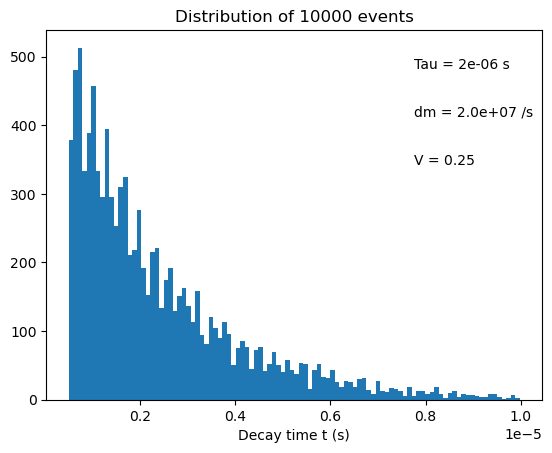

Integral of normalised pdf over bounds: 0.9999822402104821


In [59]:

# plot the histogram
plt.hist(samples, bins=100)
plt.title("Distribution of 10000 events")
plt.xlabel("Decay time t (s)")

plt.figtext(0.7, 0.8, "Tau = {0} s".format(tau_nom))
plt.figtext(0.7, 0.7, "dm = {0:.1e} /s".format(dm_nom))
plt.figtext(0.7, 0.6, "V = {0}".format(V_nom))
plt.show()


# check normalisation of pdf
print("Integral of normalised pdf over bounds: {0}".format(integrate.quad(norm_pdf, bounds[0], bounds[1], args=(tau_nom, dm_nom, V_nom))[0])) # therefore norm_pdf is normalised


- Using iminuit, fit to these generated samples with the same $\tau$, $\Delta m$ and $V$ parameter values and obtain the error on the fit

In [60]:

# use iminuit to fit 
NLL = UnbinnedNLL(samples, norm_pdf) # the NLL
m = Minuit(NLL, tau=tau_nom, dm=dm_nom, V=V_nom) # initial values as nominal values


# set boundaries for the parameters
#m.limits['tau'] = (1e-6, 2e-6) # tau always reaches upper bound??? - tau blows up???
#m.limits['dm'] = (10e6, 30e6)
#m.limits['V'] = (-1, 1)


# minimise
m.migrad() # find min of NLL
#m.simplex() # try simplex instead of migrad
m.hesse() # find errors


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.44e+05                  │              Nfcn = 62               │
│ EDM = 2.98e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau  │ 1.967e-6  │ 0.022e-6  │            │            │         │         │       │
│ 1 │ dm   │ 19.991e6  │  0.017e6  │            │            │         │         │       │
│ 2 │ V    │   0.262   │   0.014   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────┐
│     │             tau              dm               V │
├─────┼─────────────────────────────────────────────────┤
│ tau │        4.79e-16 2.4734416734e-6     -9.5043e-12 │
│  dm │ 2.4734416734e-6        2.77e+08         1.81874 │
│   V │     -9.5043e-12         1.81874        0.000184 │
└─────┴─────────────────────────────────────────────────┘

In [77]:
print(m.values["dm"] + m.errors["dm"])


-1487970.7365417134


- Do this for multiple pseudoexperiments and calculate the mean and standard deviation of the distribution of fitted parameters

In [27]:

# for loop over number of pseudoexperiments
tau_values, dm_values, V_values = [], [], [] # lists to contain obtained parameter values from each pseudoexperiment
pseudo = 100 # number of pseudoexperiments

for i in range(pseudo):
    
    # interpolation points
    x = np.linspace(bounds[0], bounds[1], 1000) 

    # cdf values
    cdf_values = np.array([cdf(i, tau_nom, dm_nom, V_nom) for i in x])

    # random r's
    r = np.random.rand(10000)

    # inverse transform sampling
    interpolator = interp1d(cdf_values, x)
    samples = interpolator(r) # our generated decay times

    # fitting
    NLL = UnbinnedNLL(samples, norm_pdf) 
    m = Minuit(NLL, tau=tau_nom, dm=dm_nom, V=V_nom)

    # parameter boundaries
    m.limits['tau'] = (1e-6, 2e-6) # tau always reaches upper bound
    m.limits['dm'] = (10e6, 30e6)
    m.limits['V'] = (-1, 1)

    # minimise
    m.migrad()

    # collect fitted parameter values
    tau_values.append(m.values["tau"])
    dm_values.append(m.values["dm"])
    V_values.append(m.values["V"])
    

tau_values, dm_values, V_values = np.array(tau_values), np.array(dm_values), np.array(V_values) # convert to np arrays
tau_mean, dm_mean, V_mean = np.average(tau_values), np.average(dm_values), np.average(V_values) # mean
tau_std, dm_std, V_std = np.std(tau_values), np.std(dm_values), np.std(V_values) # standard deviation

print("Pseudoexperiments: {0}".format(pseudo))
print("\ntau mean: {0} \ndm mean: {1} \nV mean: {2}".format(tau_mean, dm_mean, V_mean))
print("\ntau std: {0} \ndm std: {1} \nV std: {2}".format(tau_std, dm_std, V_std))

Pseudoexperiments: 100

tau mean: 1.9999999999953607e-06 
dm mean: 20004754.49587364 
V mean: 0.20985497353254462

tau std: 2.836125556052757e-17 
dm std: 19140.86886636291 
V std: 0.013691309235557027


- Plot parameter value distributions over the pseudoexperiments

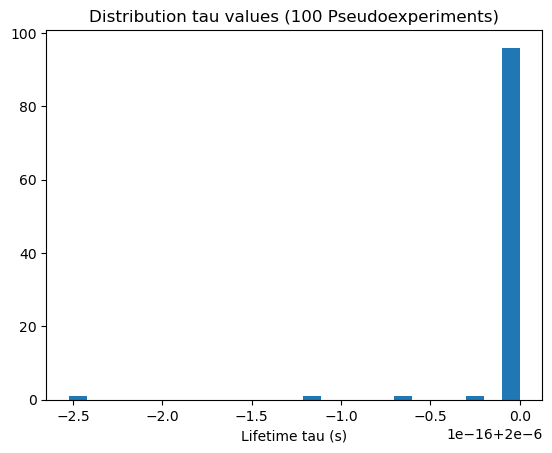

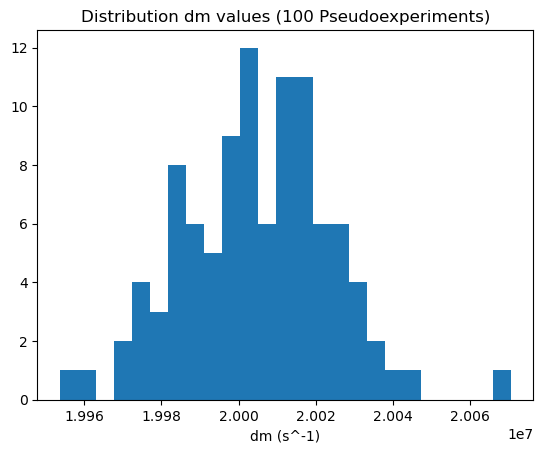

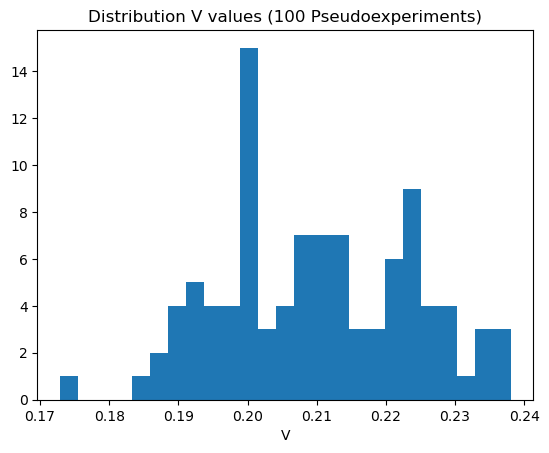

In [28]:
# plot as histograms
plt.hist(tau_values, bins=25)
plt.title("Distribution tau values ({} Pseudoexperiments)".format(pseudo))
plt.xlabel("Lifetime tau (s)")
plt.show()

plt.hist(dm_values, bins=25)
plt.title("Distribution dm values ({} Pseudoexperiments)".format(pseudo))
plt.xlabel("dm (s^-1)")
plt.show()

plt.hist(V_values, bins=25)
plt.title("Distribution V values ({} Pseudoexperiments)".format(pseudo))
plt.xlabel("V")
plt.show()

## Step 2: Effect of a background

- the pdf for the background is: $$p(t;\sigma) \propto e^{-\frac{t^2}{2\sigma^2}}$$
$$\sigma = 0.5\times 10^{-6}\ \text{s}$$
- combine data pdf and background pdf with a mixer function for proportions: 1%, 10% and 20% background

In [7]:

# given sigma value
sigma_nom = 0.5e-6


# define signal and background pdfs (neither normalised)
def signal_pdf(t, tau, dm, V):
    return (1 + V*np.sin(dm*t))*np.exp(-t/tau)

def background_pdf(t, sigma):
    return np.exp((-t**2)/2*(sigma**2))


# normalisation constants for signal and background pdfs
N_signal = integrate.quad(signal_pdf, bounds[0], bounds[1], args=(tau_nom, dm_nom, V_nom))[0] # index 0 so as not to include the error
N_background = integrate.quad(background_pdf, bounds[0], bounds[1], args=(sigma_nom))[0]


# define normalised signal and background pdfs
def norm_signal_pdf(t, tau, dm, V):
    return signal_pdf(t, tau, dm, V) / N_signal

def norm_background_pdf(t, sigma):
    return background_pdf(t, sigma) / N_background


In [8]:

# put all this in a function with argument f for background proportion
def generate_samples(f):
    # define mixer function
    def mix(t, sigma, tau, dm, V):
        return f*norm_background_pdf(t, sigma) + (1-f)*norm_signal_pdf(t, tau, dm, V)


    # define cdf
    def cdf(x, sigma, tau, dm, V):
        return integrate.quad(mix, bounds[0], x, args=(sigma, tau, dm, V))[0] # integrate from lower bound to given x


    # interpolation points
    x = np.linspace(bounds[0], bounds[1], 1000)


    # cdf values
    cdf_values = np.array([cdf(i, sigma_nom, tau_nom, dm_nom, V_nom) for i in x])


    # random r's
    r = np.random.rand(10000)


    # inverse transform sampling
    interpolator = interp1d(cdf_values, x)
    samples = interpolator(r) # our generated decay times
    
    return samples # call function with argument f and return the array of generated samples


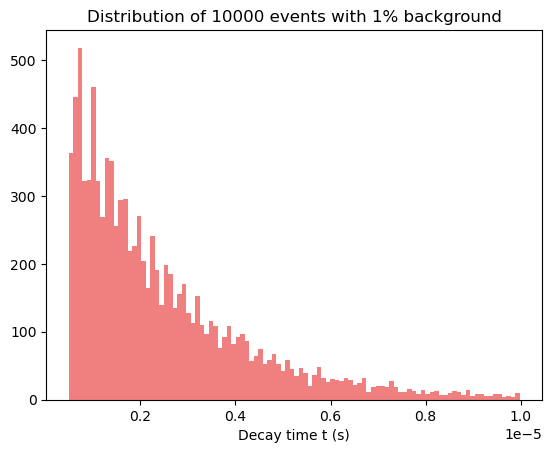

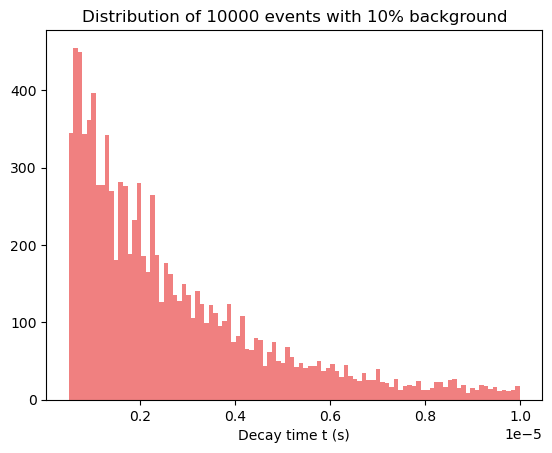

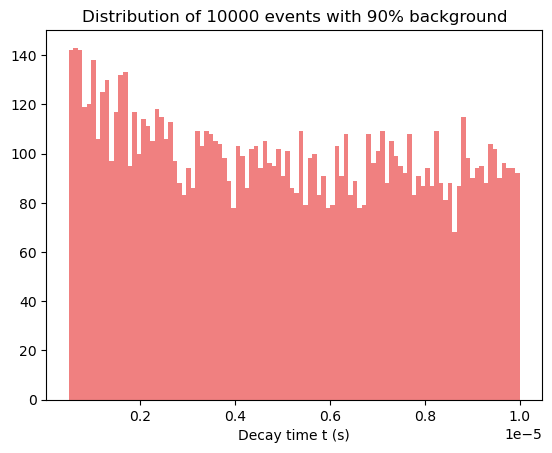

In [9]:
# plot the histogram for 1%, 10% and 20% background
plt.hist(generate_samples(0.01), bins=100, color="lightcoral")
plt.title("Distribution of 10000 events with 1% background")
plt.xlabel("Decay time t (s)")
plt.show()


plt.hist(generate_samples(0.1), bins=100, color="lightcoral")
plt.title("Distribution of 10000 events with 10% background")
plt.xlabel("Decay time t (s)")
plt.show()


plt.hist(generate_samples(0.9), bins=100, color="lightcoral")
plt.title("Distribution of 10000 events with 90% background")
plt.xlabel("Decay time t (s)")
plt.show()

- Fit pseudoexperiments